In [294]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data pre-processing
from scipy.io import loadmat
from scipy.ndimage import convolve1d

# Machine Learning
from sklearn.svm import SVC 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV


# Part 1

## 1.1 Visualize and preprocess the data
Note: data is already partially preprocessed on the original database

### Loading and visualizing data
Starting with subject 2

In [279]:
# load EMG data
data = loadmat("data/Part 1/S2_A1_E1.mat")

# Performing a copy of the data
emg_rectified = data["emg"].copy()
#Stimulus is the type of movement that is being performed
stimulus = data["restimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data["rerepetition"] 

print(f'Shape of Data \n    EMG: {emg_rectified.shape}\n    Stimulus {stimulus.shape}\n   Repetition {repetition.shape}')

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg_rectified.shape[1]

print('***')
print(f'Number of \n    Movements: {n_stimuli}\n    Repetitions: {n_repetitions}')


Shape of Data 
    EMG: (100686, 10)
    Stimulus (100686, 1)
   Repetition (100686, 1)
***
Number of 
    Movements: 12
    Repetitions: 10


### Visualizing the stimulus and repetitions values

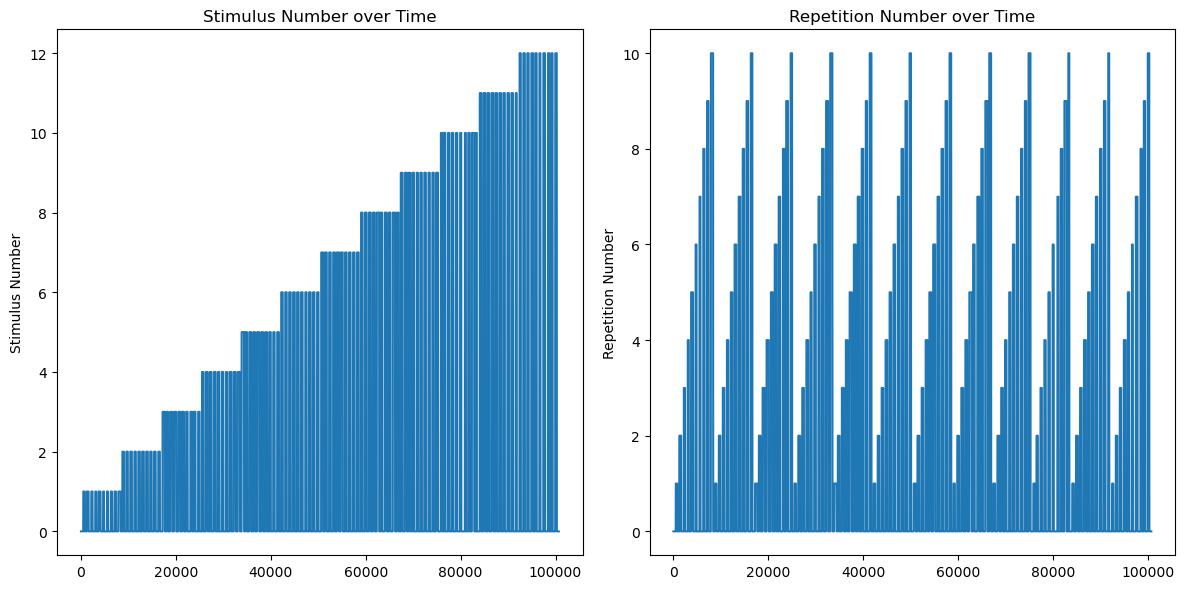

In [280]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(stimulus)
ax[0].set_title('Stimulus Number over Time')
ax[0].set_ylabel('Stimulus Number')
ax[1].plot(repetition)
ax[1].set_title('Repetition Number over Time')
ax[1].set_ylabel('Repetition Number')
plt.tight_layout()
plt.show()

### Visualizing the length of the repetitions for each movement

In [281]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))
        #print(f"Movement #{stimuli_idx+1} - Repetition #{repetition_idx+1}")

number_of_samples_per_trial

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

### Plotting the 10 EMG Channels to discard faulty recordings
Visualizing each channel across different movements and repetitions to identify weird-looking data

In [282]:
#defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 

Text(0.5, 0.98, 'Envelopes of the EMG signal')

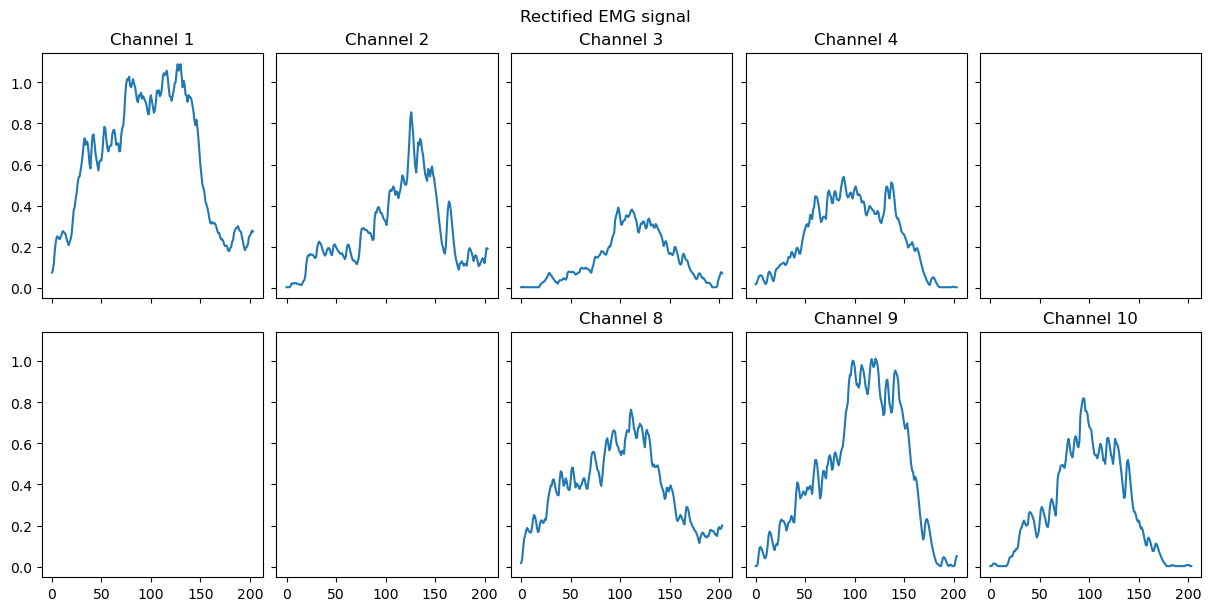

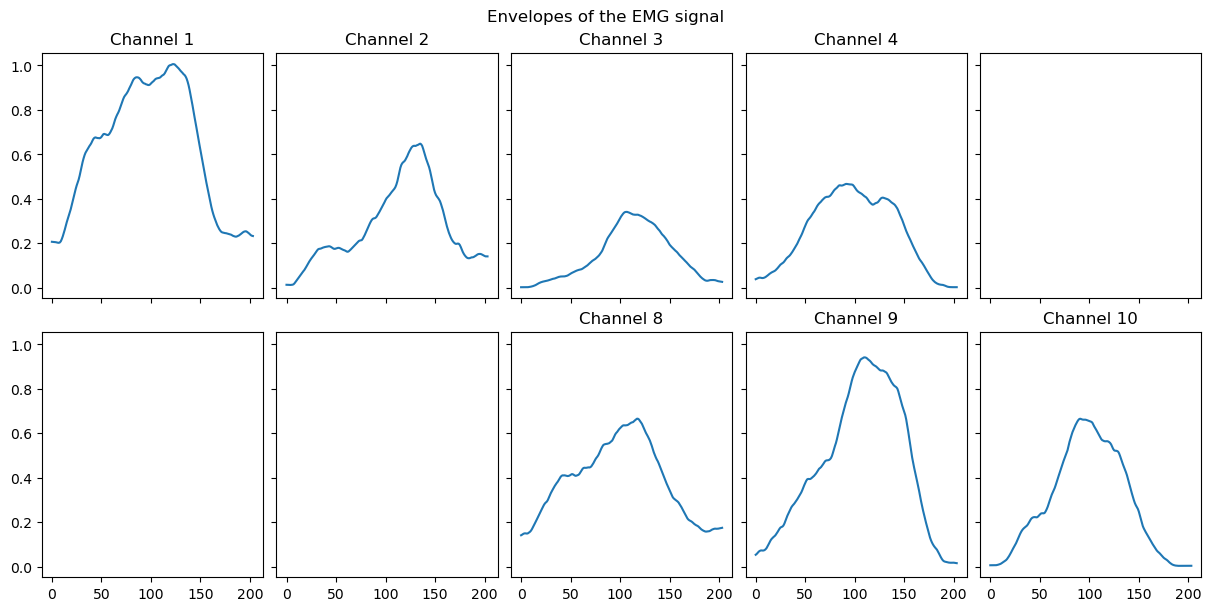

In [283]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

# Selecting the stimulus and repetition to plot the 10 EMG channels
number_of_emg_channels = emg_rectified.shape[-1]
stimulus_id = 11
repetition_id = 5

# Discarding channels with weird data (Pay attention that channel_id = Channel_number - 1 on the plot !)
channels_to_discard = {4, 5, 6}

# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    if channel_idx in channels_to_discard:
        continue
    ax[channel_idx].plot(emg_windows[stimulus_id][repetition_id][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    if channel_idx in channels_to_discard:
        continue
    ax[channel_idx].plot(emg_envelopes[stimulus_id][repetition_id][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

### Removing useless EMG channels
Channels 4, 5, and 6 are discarded after visual inspection since they appear to contain poor quality recordings 

In [284]:
# Keeping only the clean EMG channels
channels_kept = [i for i in range(number_of_emg_channels) if i not in channels_to_discard]
kept_emg_data = np.delete(emg_rectified, list(channels_to_discard), axis=1)
number_of_kept_channels = len(channels_kept)

print(f"Number of channels kept: {number_of_kept_channels}")
print(f"New shape of the EMG data: {kept_emg_data.shape}")

Number of channels kept: 7
New shape of the EMG data: (100686, 7)


## 1.2 Splitting data into train-test-val

### Step 1: Select & Define the features of interest

In [285]:
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis = 0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(x, axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum(np.diff(np.sign(np.diff(x, axis=0)), axis=0) != 0, axis=0)
# Variance
var = lambda x: np.var(x, axis=0)

### Step 2: Build the dataset

In [286]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

# Selecting the features of interest
features_names = ['mav', 'std', 'maxav', 'rms', 'wl', 'ssc', 'var']
features = [mav, std, maxav, rms, wl, ssc, var]

dataset, labels = build_dataset_from_ninapro(
    emg=kept_emg_data,
    stimulus=stimulus,
    repetition=repetition,
    features=features
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")

dataset dimension: (120, 49)
labels dimension: (120,)


### Step 3: Split the dataset into Train-Test (Validation split done later in cross-validation)

In [287]:
# Splitting into Training (75%) and Testing Set (25%)
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.25)

# Standardizing data w.r.t to X_train
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_test_z = scaler.transform(X_test)   
print(f"Shapes =  X_train: {X_train_z.shape} | X_test: {X_test_z.shape}")

Shapes =  X_train: (90, 49) | X_test: (30, 49)


## 1.3 Extract features from the trials

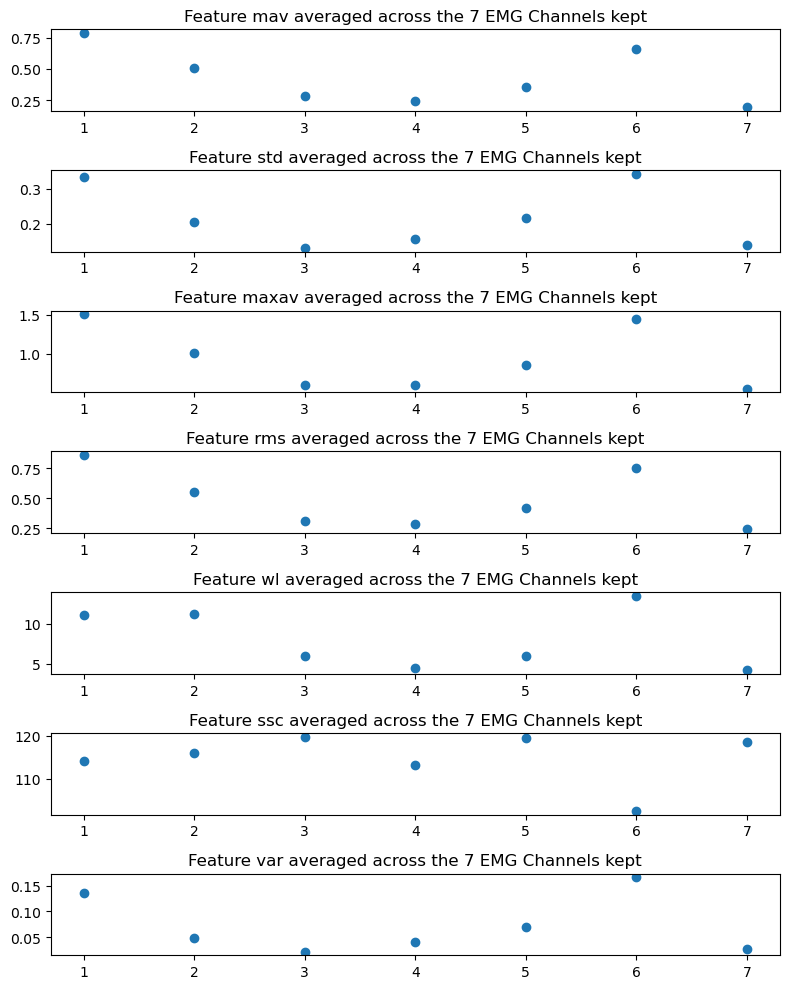

In [288]:
# Visualize values of the features across channels
# Plotting the features for each channel across the 12 movements
x_axis = np.arange(1, number_of_kept_channels+1)
fig, axs = plt.subplots(len(features), 1, figsize = (8,10))
for i, feature in enumerate(features_names):
    feature_channels = []
    for channel_idx in range(number_of_kept_channels): # Looping through each EMG channel for each feature
        idx_feature = i * number_of_kept_channels + channel_idx
        feature_channels.append(np.mean(dataset[:, idx_feature], axis = 0)) # Averaging over all 120 (movements + repetitions)
    axs[i].set_title(f"Feature {feature} averaged across the 7 EMG Channels kept")
    axs[i].scatter(x_axis, feature_channels)

plt.tight_layout()
plt.show()

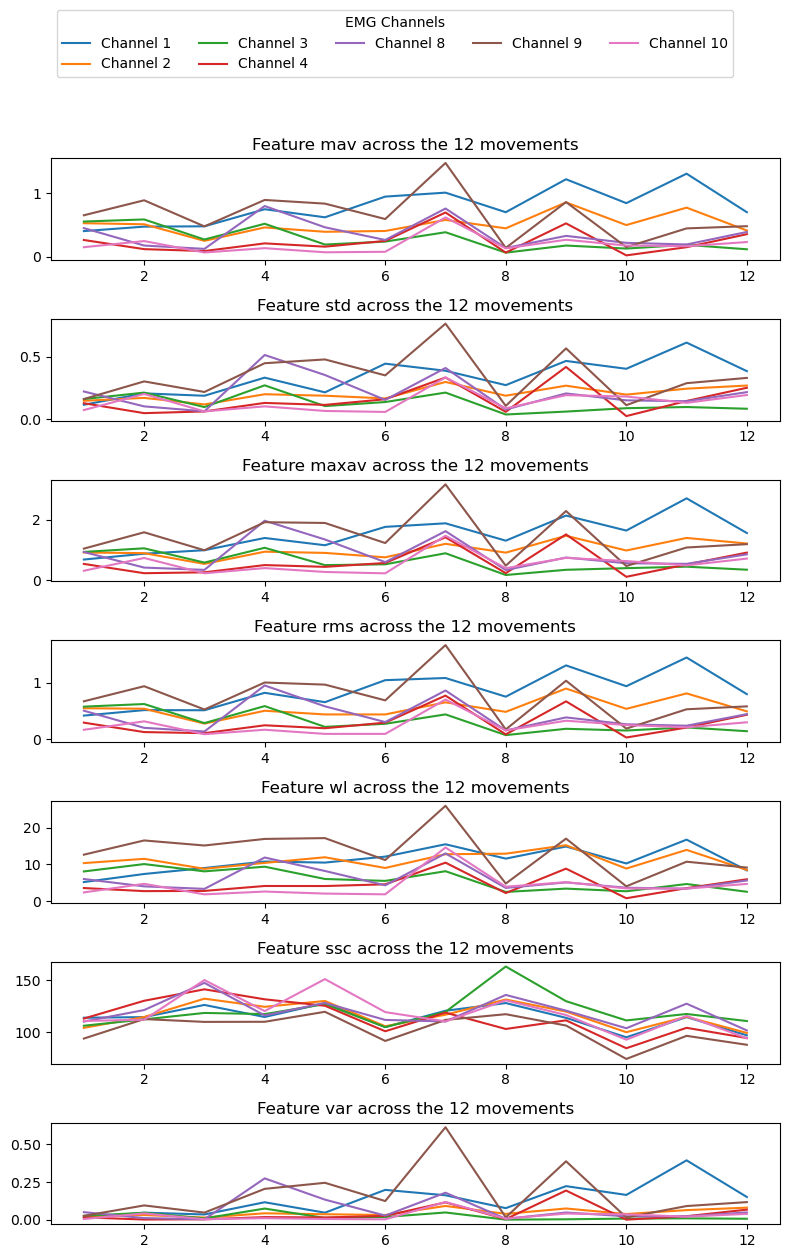

In [289]:
# Visualize values of the features across movements
# X_axis: 12 movements
# Y_axis: value of the feature
# Each curve in the plot represent the value averaged over the repetitions for each channel

x_axis = np.arange(1, n_stimuli+1)
fig, axs = plt.subplots(len(features_names), 1, figsize=(8, 12))

# Store the labels for each EMG channel
channel_labels = [f"Channel {i+1}" for i in channels_kept]

# To collect handles for the legend
lines = []

for i, feature in enumerate(features_names):
    feature_stimuli = np.zeros((n_stimuli, number_of_kept_channels)) # Will end up having 12 x 10 values for each movement for each channel
    # Focusing on the relevant feature across the 10 EMG channels
    feature_idx = i * number_of_kept_channels + np.arange(number_of_kept_channels)
    for j in range(n_stimuli):
        # Calculate the indices for repetitions of the current stimulus
        idx_repetitions = np.arange(j * n_repetitions, (j + 1) * n_repetitions)

        # Take the average of the feature values for the current stimulus and repetitions
        feature_stimuli[j,:] = np.mean(dataset[idx_repetitions[:, None], feature_idx], axis=0) # Taking the averages for each channel across the 10 repetitions
        
    # Plot the feature values for each channel across movements
    axs[i].set_title(f"Feature {feature} across the 12 movements")
    for l in range(number_of_kept_channels):
        line, = axs[i].plot(x_axis, feature_stimuli[:, l], label=channel_labels[l])
        if i == 0:  # Collect lines for legend only once
            lines.append(line)

# Add a common legend outside the subplots
fig.legend(lines, channel_labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, title="EMG Channels")

# Adjust layout to accommodate the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 1.4 Perform classification on the data

### Hyperparameters optimization

In [290]:
# Define the SVM model
svc = SVC()

# Define the grid search
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': [1e-3, 1e-2, 0.1, 1, 10],
    'degree': [2, 3, 4]  # Only relevant for 'poly' kernel
}

# Performing the grid search with a 5-fold cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='f1_macro', refit=True, cv=5, verbose=1)

# Fit the grid search
grid_search.fit(X_train_z, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best hyperparameters: {'C': 0.1, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear'}


## 1.5 Evaluate the performance

F1-score score: 0.9389


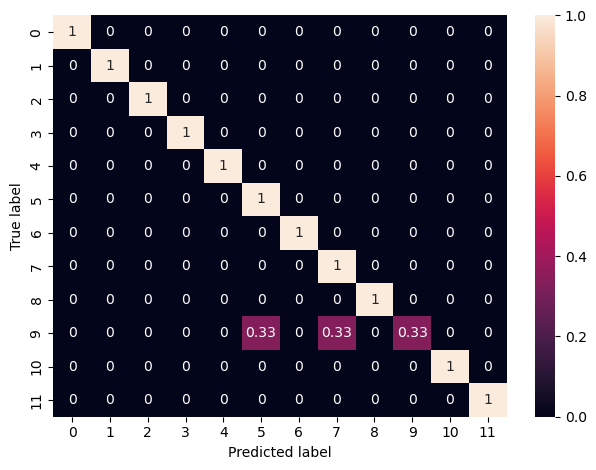

In [312]:
# Training the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_z, y_train)

# Evaluate on the test set
y_pred = best_model.predict(X_test_z)
f1_score_test = f1_score(y_test, y_pred, average='macro')
print(f"F1-score score: {round(f1_score_test, 4)}")
confmat = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the confusion matrix using a heatmap for better visualization.
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.tight_layout()

## 1.6 Perform feature selection

### Mutual information and k-best features selection

Original feature count: 49
Reduced feature count after K-Best Selection: 10
F1-score of a model with 10 best features: 0.6603


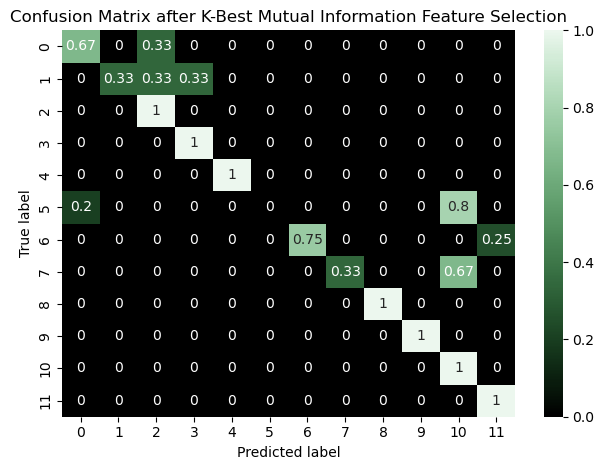

In [340]:
# Calculate mutual information between each feature and the target variable.
mutual_info = mutual_info_classif(X_train_z, y_train)
#print(f"Estimated mutual information between each feature and the target:\n {mutual_info}\n")

# Select the top 10 features based on mutual information scores.
K = 10
k_best = SelectKBest(mutual_info_classif, k=K)
k_best.fit(X_train_z, y_train)

# Transform the training and test datasets to only include the selected features.
X_train_best = k_best.transform(X_train_z)
X_test_best = k_best.transform(X_test_z)
print(f"Original feature count: {X_train_z.shape[1]}")
print(f"Reduced feature count after K-Best Selection: {X_train_best.shape[1]}")

#clf = KNeighborsClassifier(**grid.best_params_) # use the best parameters found before, You can also perform another round of grid search with the new features
best_model.fit(X_train_best, y_train) # NOTE: keeping the same model as before, not performing again a grid search for the best hyperparameters

# Predict the labels for the test set using the trained model.
y_pred = best_model.predict(X_test_best)

# Calculate the performance of the reduced model
f1_score_test = f1_score(y_test, y_pred, average = 'macro')
print(f"F1-score of a model with {K} best features: {round(f1_score_test, 4)}")

# Create a confusion matrix to visualize the performance of the classification model.
confmat = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the confusion matrix using a heatmap for better visualization.
fig, ax = plt.subplots()

# Plotting the confusion matrix
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
sns.heatmap(confmat, annot=True, ax=ax, cmap=cmap)

plt.title("Confusion Matrix after K-Best Mutual Information Feature Selection")
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.tight_layout()

### PCA Dimensionality Reduction
To remove redundancy from k-best features retained based on highest mutual information, we can also perform further dimensionality reduction using PCA

Original feature count: 10
Reduced feature count after PCA: 4
F1-score of a model with k best features: 0.6603


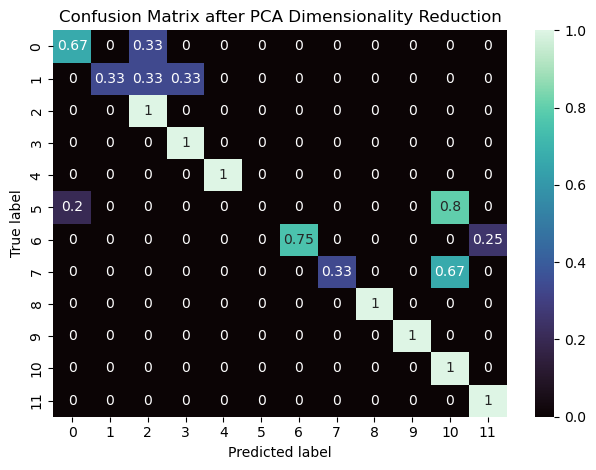

In [339]:
# Perform PCA on the selected features
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_best)
X_test_pca = pca.transform(X_test_best)

print(f"Original feature count: {X_train_best.shape[1]}")
print(f"Reduced feature count after PCA: {X_train_pca.shape[1]}")

best_model.fit(X_train_pca, y_train) # NOTE: keeping the same model as before, not performing again a grid search for the best hyperparameters

# Predict the labels for the test set using the trained model.
y_pred = best_model.predict(X_test_pca)

# Calculate the performance of the reduced model
f1_score_test = f1_score(y_test, y_pred, average = 'macro')
print(f"F1-score of a model with k best features: {round(f1_score_test, 4)}")

# Create a confusion matrix to visualize the performance of the classification model.
confmat = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the confusion matrix using a heatmap for better visualization.
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax, cmap = 'mako')

plt.title("Confusion Matrix after PCA Dimensionality Reduction")
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.tight_layout()